# **Tutorial 4: Return Levels Using Normal and GEV Distributions**

**Week 2, Day 4, Extremes & Vulnerability**

**Content creators:** Matthias Aengenheyster, Joeri Reinders

**Content reviewers:** Younkap Nina Duplex, Sloane Garelick, Zahra Khodakaramimaghsoud, Peter Ohue, Laura Paccini, Jenna Pearson, Agustina Pesce, Derick Temfack, Peizhen Yang, Cheng Zhang, Chi Zhang, Ohad Zivan

**Content editors:** Jenna Pearson, Chi Zhang, Ohad Zivan

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS

# **Tutorial Objectives**

Now that we have learned how to create a PDF for the GEV distribution, we can utilize it to calculate return values based on this distribution.

Return levels are computed from a PDF using the [cumulative distribution function (CDF)](https://en.wikipedia.org/wiki/Cumulative_distribution_function), which provides the probability that a randomly drawn variable from our distribution will be less than a certain value X (for our specific variable). Extreme events are rarer, and thus the probability of a precipitation event being at or lower than it is high.  For example, if there is a 99% chance of observing a storm with 80mm of rainfall or lower, it means that there is a 1% chance of observing a storm with at least 80mm of rainfall. This implies that the 100-year storm would bring 80mm of rain. In simple terms, the return level is the inverse of the CDF.

By the end of this tutorial, you will be able to:

- Estimate return levels using a given quantile and the parameters of a GEV distribution.
- Compare return level plots for GEV and normal distributions.

# **Setup**

In [1]:
# !pip install -q condacolab
# import condacolab
# condacolab.install()

# !pip install numpy
# !pip install matplotlib
# !pip install seaborn
# !pip install pandas
# !pip install cartopy
# !pip install scipy


In [1]:
# imports 
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import pooch

from scipy import stats
from scipy.stats import genextreme as gev

In [2]:
# @title Figure Settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")

In [3]:
# @title Video 1: Speaker Introduction
#Tech team will add code to format and display the video

# **Section 1: Return Levels and Return Periods**

As before let's load the annual maximum precipitation data from Germany:

In [4]:
# download file: 'precipitationGermany_1920-2022.csv'
url_precipitationGermany = "https://osf.io/xs7h6/download"


data = pd.read_csv(pooch.retrieve(url_precipitationGermany, known_hash=None),
                   index_col=0).set_index('years')
data.columns=['precipitation']
precipitation = data.precipitation

And fit the General Extreme Value (GEV) distribution:

In [27]:
shape, loc, scale = gev.fit(precipitation.values,0)
shape, loc, scale

(-0.04713587000734158, 26.353581930592185, 7.369405343826601)

To compute return levels, you can use the function estimate_return_level_from_params(x, location, scale, shape) defined below. In this case, x represents the probability of a random value from our distribution being lower. For example, for the 100-year storm, x would be 0.99, and for the 1000-year storm, it would be 0.999.

This utility function takes a given *quantile* and the GEV parameters (loc, scale, shape) and computes the corresponding return level.

In [6]:
def estimate_return_level(quantile,loc,scale,shape):
    level = loc + scale / shape * (1 - (-np.log(quantile))**(shape))
    return level

Now, let's utilize this function to calculate the 2-year return level, which represents the precipitation level we anticipate with a 50% chance each year. The function requires the quantile value 'x' and three parameters related to GEV (Generalized Extreme Value) distribution: location, scale, and shape. The function will provide the return level corresponding to the given quantile.
For instance, the 90th quantile (x=0.9) would yield the precipitation value expected once every 10 years (with a 10% chance of observing it each year).

In [7]:
estimate_return_level(0.5,loc,scale,shape)

29.07803009997505

This function is also available as part of the scipy GEV implementation - here called the "Percent point function" or ppf which you used previously to make the quantile-quantile plots in the last tutorial.

In [29]:
gev.ppf(0.5,shape,loc=loc,scale=scale)

29.07803009997506

To make things easier, let's replace x with the formula 1-(1/return period). Note this is different than the exceedence probability discussed in tutorial 2. So a 100-year storm would, we would use 1-(1/100) = 0.99. Compute return level for the 100- and 1000-year storm. 

In [10]:
estimate_return_level(1-1/100,loc,scale,shape)

64.20998052543192

In [11]:
estimate_return_level(1-1/1000,loc,scale,shape)

86.51985389906702

Now we will make a figure in which we plot return-levels against return-periods:
1. Create a vector “periods” which is a sequence of 2 to a 1000-years (with a step size of 2).
2. Calculate the associated return-levels for those return periods.
3. Plot the return levels against the return periods. Typically, the return periods go on the x-axis at a log-scale.


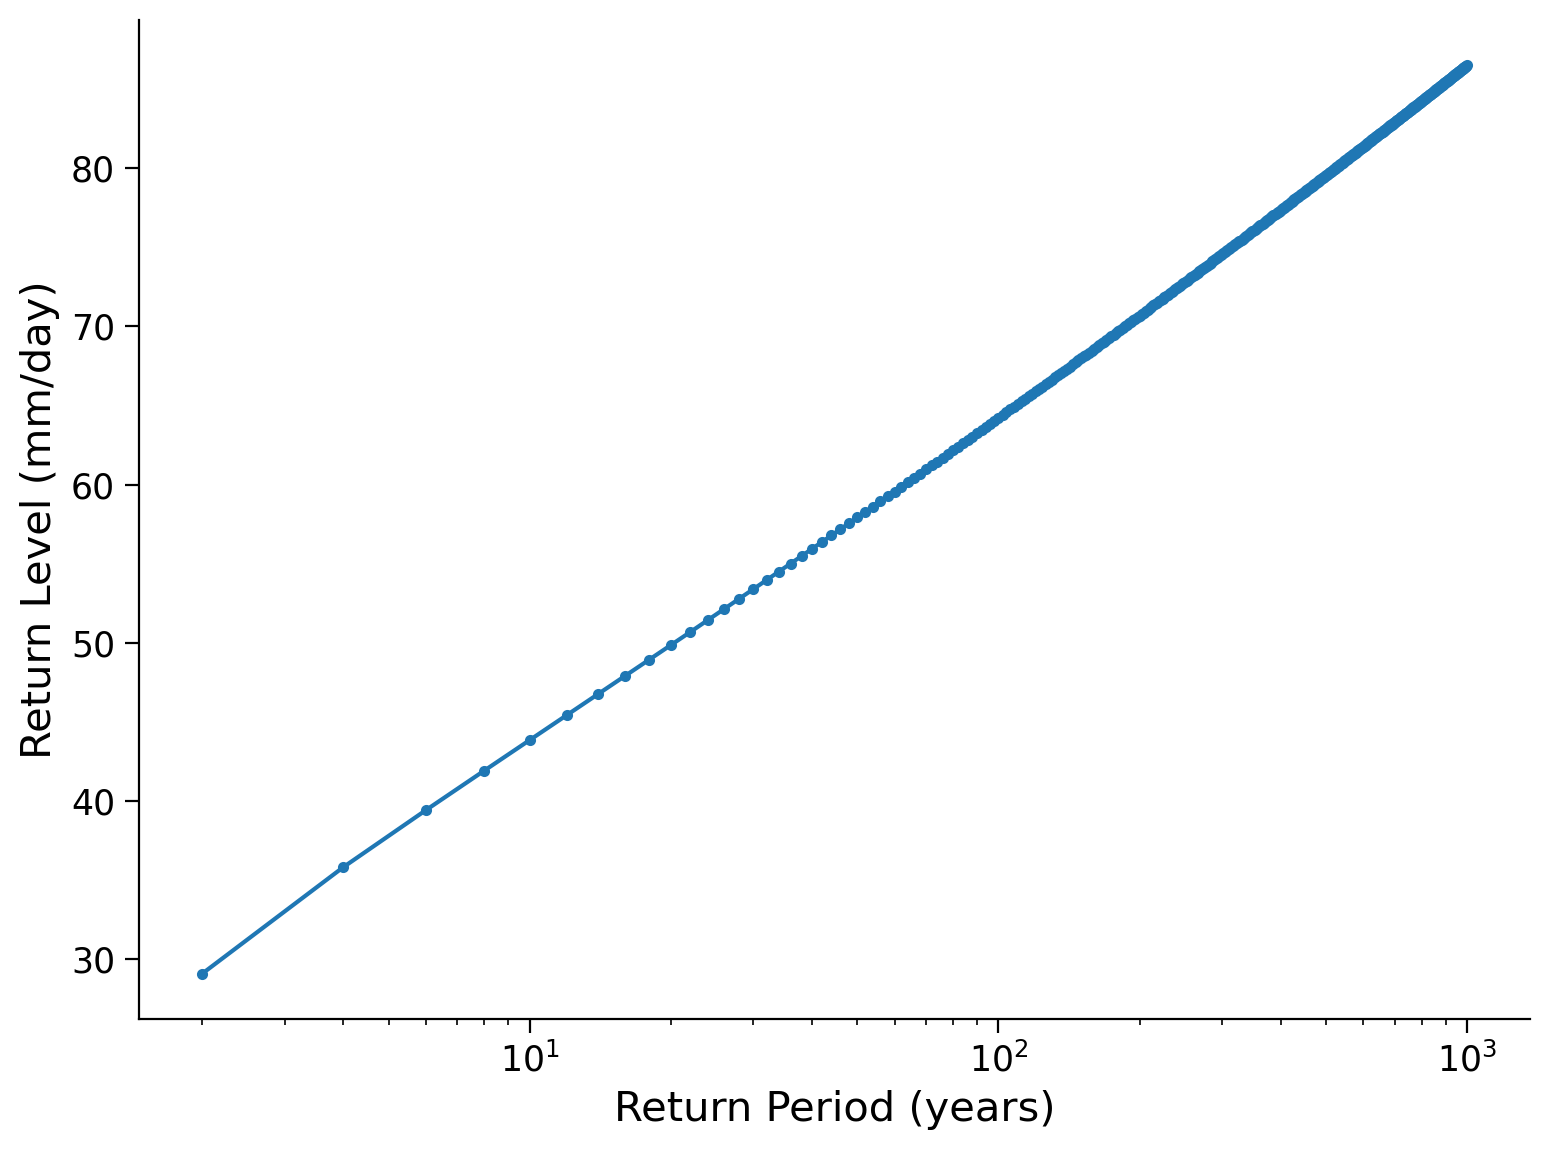

In [12]:
periods = np.arange(2,1000,2)
quantiles = 1-1/periods
levels = estimate_return_level(quantiles,loc,scale,shape)

fig,ax=plt.subplots()
ax.plot(periods,levels,'.-')
ax.set_xlabel('Return Period (years)')
ax.set_ylabel('Return Level (mm/day)')
ax.set_xscale('log')


## **Coding Exercise 1**

Compute and plot the 50-,100-,500- and 1000-year return levels based on a normal distribution and based on the Normal and GEV distributions.

Plot these three things:
1. the empirical return level
2. the estimate based on a normal distribution
3. the estimate based on a GEV distribution

*Note that you can get the empirical return levels from tutorial 2, we will provide this code below.*

In [15]:
def empirical_return_level(data):
    '''
    Compute empirical return level using the algorithm introduced in Tutorial 2
    '''
    df = pd.DataFrame(index=np.arange(data.size))
    # sort the data
    df['sorted'] = np.sort(data)[::-1]
    # rank via scipy instead to deal with duplicate values
    df['ranks_sp'] = np.sort(stats.rankdata(-data))
    # find exceedence probability
    n = data.size
    df['exceedance'] = df['ranks_sp']/(n+1)
    # find return period
    df['period'] = 1 / df['exceedance']

    df = df[::-1]

    out = xr.DataArray(
        dims=['period'],
        coords={'period':df['period']},
        data=df['sorted'],name='level')
    return out


In [34]:
#################################################
# Students: Fill in missing code (...) and comment or remove the next line
raise NotImplementedError("Student exercise:  Create QQ plots for empircal, normal and GEV distribution return values.")
#################################################

# setup plots
fig,ax=plt.subplots()

# get empirical return levels
empirical_return_level(...).plot(...)

# create vector of years
years = np.arange(1.1,100,0.1)

# calculate and plot the normal return levels
ax.plot(years,stats.norm.ppf(...,loc=..., scale=...))

# calculate and plot the GEV distribution, note the negtive shape parameter
ax.plot(years,gev.ppf(...,...,loc=...,scale=...))

# set x axis to log scale
ax.set_xscale('log')

# show legend
ax.legend(['empirical','normal','GEV'])

NotImplementedError: Student exercise:  Create QQ plots for empircal, normal and GEV distribution return values.

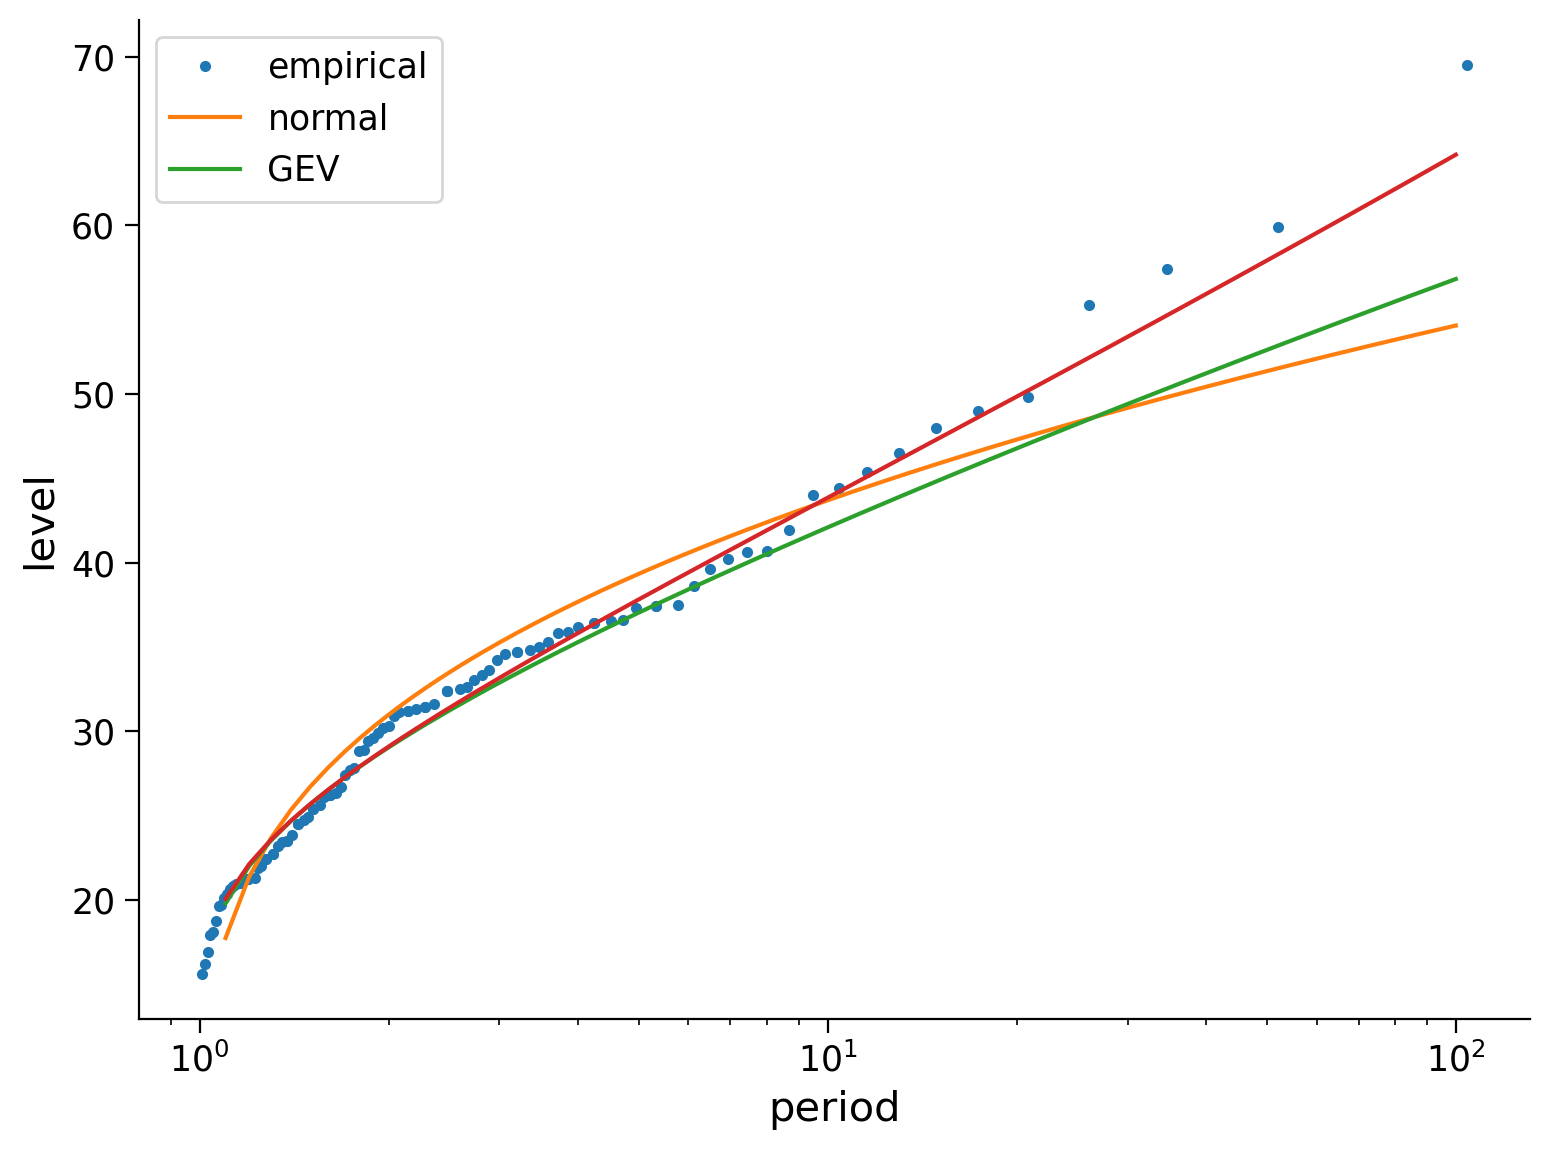

In [46]:
# to_remove solution

# setup plots
fig,ax=plt.subplots()

# get empirical return levels
empirical_return_level(precipitation).plot(ax=ax,marker='.', linestyle='None')

# create vector of years
years = np.arange(1.1,100,0.1)

# calculate and plot the normal return levels
ax.plot(years,stats.norm.ppf(1-1/years,loc=precipitation.mean(), scale=precipitation.std()))

# calculate and plot the GEV distribution, note the negtive shape parameter
ax.plot(years,gev.ppf(1-1/years,-shape,loc=loc,scale=scale))
ax.plot(years,gev.ppf(1-1/years,shape,loc=loc,scale=scale))
# set x axis to log scale
ax.set_xscale('log')

# show legend
ax.legend(['empirical','normal','GEV'])

## **Question 1**

1. What can you say about the plot and how the distributions describe the data? How do the distributions differ? At short/long return periods? What will happen at even longer return periods?

In [18]:
# to_remove explanation
"""
Put your observations here. GEV distribution describes the data better than the normal distribution. However, they are similar for shorter return periods. This suggests that for common, less extreme events (short return periods), both the Normal and GEV distributions provide a similar representation of the data. This similarity is likely due to the fact that for less extreme events, the tail of the distribution (which captures extreme events) is less relevant. When we move toards longer return periods (which correspond to more extreme events), the two curves start to diverge.
""";

## **Bonus: Find Confidence Intervals**

One possible approach could involve the following steps:

1. Begin with the `gev` function which can be employed to fit GEV parameters using `gev.fit(data)`. This function returns the three parameters, taking note of a sign change in the shape parameter (as different conventions exist).
2. Determine the number of observations in the data, denoted as N.
3. Perform resampling by randomly drawing N samples from the data with replacement. This process generates an artificial ensemble that differs from the true data due to resampling.
4. Estimate the parameters for each resampling.
5. Utilize the `gev.ppf` function for each parameter set to compute the return level.
6. Visualize the resulting uncertainty bands by plotting multiple lines or calculating confidence intervals using `np.quantile`.

In [44]:
#################################################
# Students: Fill in missing code (...) and comment or remove the next line
raise NotImplementedError("Student exercise:  Fill in the code following the steps above.")
#################################################


# initalize list to store parameters from samples
params = []

# generate 1000 samples by resampling data with replacement
for i in range(1000):
    params.append(gev.fit(np.random.choice(...,...,...)))
    
# print the estimate of the mean of each parameter and it's confidence intervals
print('Mean estimate: ',np.mean(np.array(params),axis=0),' and 95% confidence intervals: ',np.quantile(np.array(params),[0.025,0.975],axis=0))

# generate years vector
years = np.arange(1.1,1000,0.1)

# intialize list for return levels
levels = []

# calculate return levels for each of the 1000 samples
for i in range(1000):
    levels.append(gev.ppf(...,*params[i]))
levels = np.array(levels)

# setup plots
fig,ax=plt.subplots()

# find empirical return levels
empirical_return_level(...).plot(ax=ax,marker='.', linestyle='None')

# plot return mean levels
ax.plot(years,levels.mean(axis=0))

# plot confidence intervals
ax.plot(years,np.quantile(levels,[0.025,0.975],axis=0).T,'k--')

# aesthetics
ax.set_xlim(1.5,1000)
ax.set_ylim(20,110)
ax.set_xscale('log')
ax.set_xlabel('Return Period (years)')
ax.set_ylabel('Return Level (mm/day)')

NotImplementedError: Student exercise:  Fill in the code following the steps above.

Mean estimate:  [-0.04396634 26.3786976   7.29654929]  and 95% confidence intervals:  [[-0.20428582 24.63475546  6.15212004]
 [ 0.10349725 28.29318811  8.42862446]]


Text(0, 0.5, 'Return Level (mm/day)')

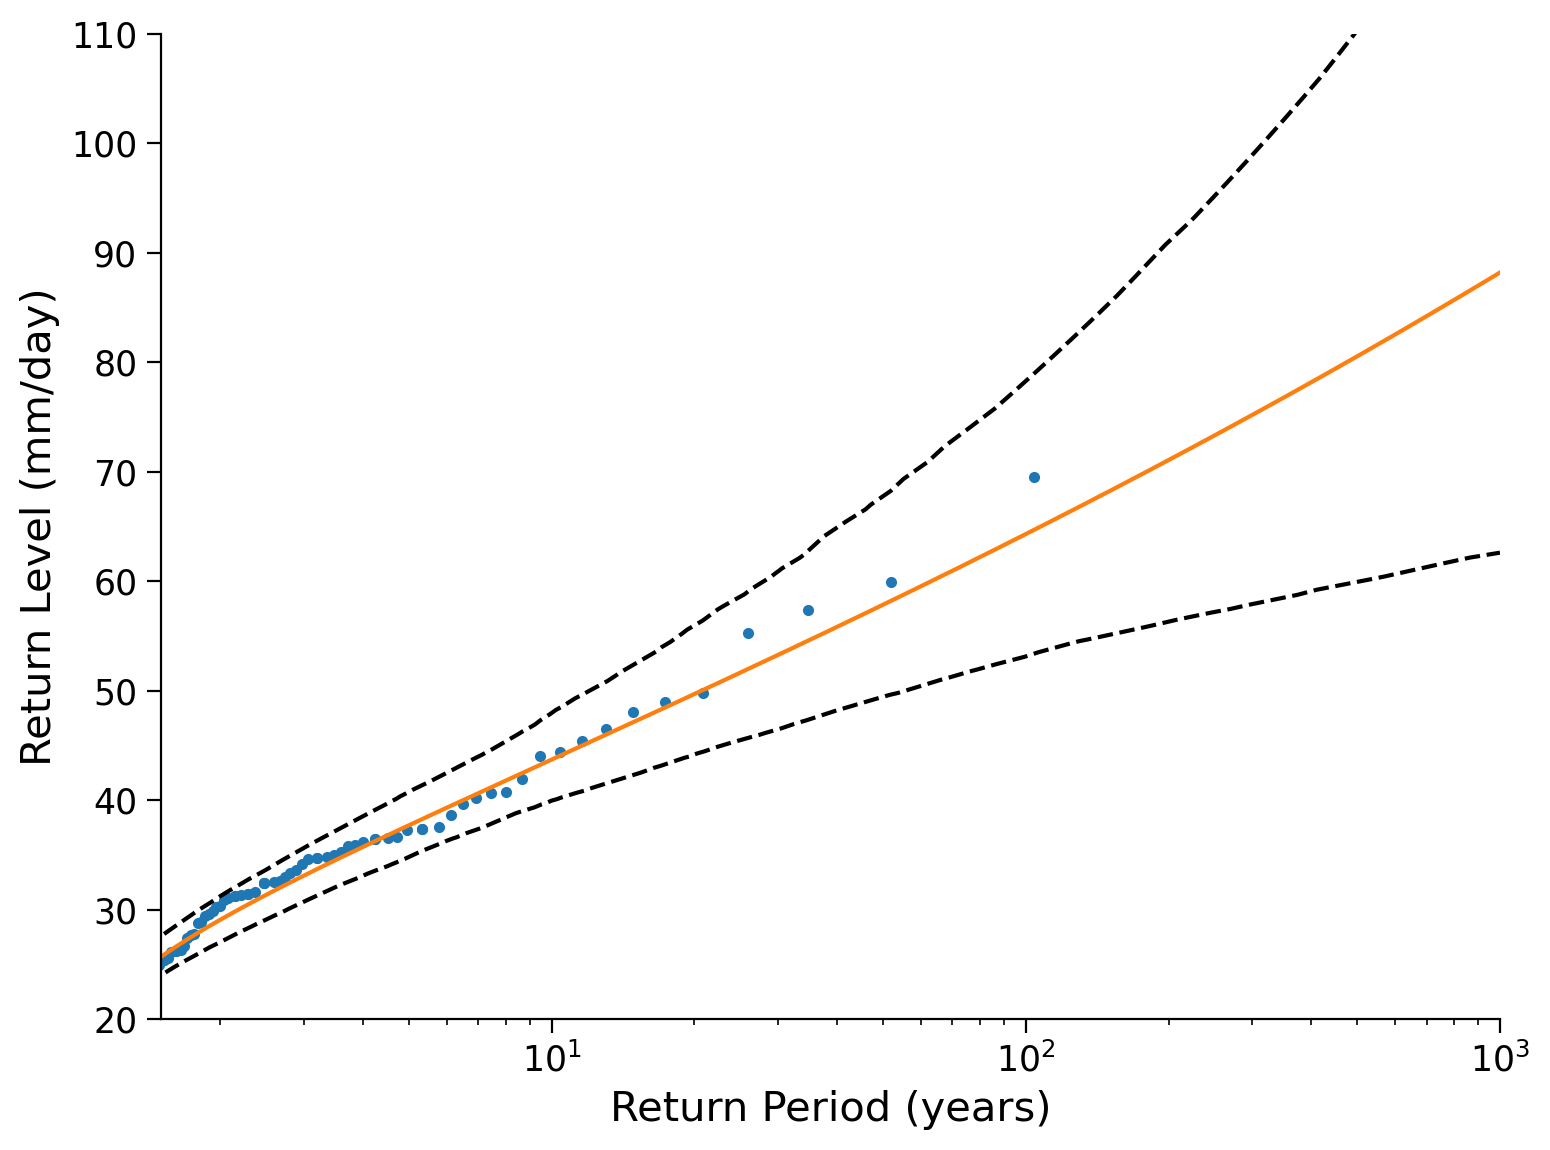

In [47]:
# to_remove solution

# initalize list to store parameters from samples
params = []

# generate 1000 samples by resampling data with replacement
for i in range(1000):
    params.append(gev.fit(np.random.choice(precipitation,size=precipitation.size,replace=True)))
    
# print the estimate of the mean of each parameter and it's confidence intervals
print('Mean estimate: ',np.mean(np.array(params),axis=0),' and 95% confidence intervals: ',np.quantile(np.array(params),[0.025,0.975],axis=0))

# generate years vector
years = np.arange(1.1,1000,0.1)

# intialize list for return levels
levels = []

# calculate return levels for each of the 1000 samples
for i in range(1000):
    levels.append(gev.ppf(1-1/years,*params[i]))
levels = np.array(levels)

# setup plots
fig,ax=plt.subplots()

# find empirical return levels
empirical_return_level(precipitation).plot(ax=ax,marker='.', linestyle='None')

# plot return mean levels
ax.plot(years,levels.mean(axis=0))

# plot confidence intervals
ax.plot(years,np.quantile(levels,[0.025,0.975],axis=0).T,'k--')

# aesthetics
ax.set_xlim(1.5,1000)
ax.set_ylim(20,110)
ax.set_xscale('log')
ax.set_xlabel('Return Period (years)')
ax.set_ylabel('Return Level (mm/day)')

# **Summary**
In this tutorial, you learned how to calculate return values based on the Generalized Extreme Value (GEV) distribution. You learned how they are derived the cumulative distribution function (CDF), and compared them to those from the normal distribution. Finally, you learned how to create confidence intervals for the parameters that define the GEV distribution for a given dataset.

# **Resources**

Data from this tutorial can be found here. NEED TO ADD LINK